## B265435 - PITDS - Assessment 3 - Python code

### Part 1: Can clustering algorithm be used to see if weather stations can be clustered into groups with “similar” weather?

In [1]:
import os
import requests
import pandas as pd
import re
import time
from pathlib import Path

# Define base URL and output directory
BASE_URL = "http://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/"
INPUT_FILE = r"C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\station.txt"
OUTPUT_DIR = os.path.join(os.path.dirname(INPUT_FILE))
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "Part1_weather_stations.xlsx")

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Function to handle file permission errors
def safe_excel_writer(output_file, max_retries=5, wait_time=5):
    for attempt in range(max_retries):
        try:
            return pd.ExcelWriter(output_file, engine='xlsxwriter')
        except PermissionError:
            print(f"Permission denied: {output_file}. Ensure the file is closed. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
    raise PermissionError(f"Could not access {output_file} after {max_retries} retries.")

# Function to extract latitude and longitude from the 2nd or 3rd line
def extract_lat_lon(lines):
    """Searches for latitude and longitude in the 2nd or 3rd line of the station file."""
    lat, lon = "Unknown", "Unknown"
    for i in range(1, min(3, len(lines))):  # Check 2nd and 3rd lines
        lat_match = re.search(r'Lat\s*[:\s]*([-+]?[\d.]+)', lines[i], re.IGNORECASE)
        lon_match = re.search(r'Lon\s*[:\s]*([-+]?[\d.]+)', lines[i], re.IGNORECASE)
        if lat_match:
            lat = lat_match.group(1)
        if lon_match:
            lon = lon_match.group(1)
    return lat, lon

# Read station names from the provided text file
with open(INPUT_FILE, "r") as file:
    stations = [line.strip() for line in file.readlines() if line.strip()]

# Create a Pandas Excel writer safely
with safe_excel_writer(OUTPUT_FILE) as writer:
    all_weather_stations = []
    for station in stations:
        url = f"{BASE_URL}{station}data.txt"
        response = requests.get(url)
        if response.status_code == 200:
            lines = response.text.split("\n")
            # Extract latitude and longitude
            latitude, longitude = extract_lat_lon(lines)
            # Locate the header line
            for i, line in enumerate(lines):
                if "yyyy" in line.lower():
                    header_index = i
                    break
            else:
                print(f"Skipping {station}: Header not found.")
                continue
            # Extract header and data
            columns = re.split(r'\s+', lines[header_index].strip())
            data = [re.split(r'\s+', line.strip()) for line in lines[header_index+1:] if line.strip()]
            # Ensure all rows have the same number of columns as the header
            data = [row for row in data if len(row) == len(columns)]
            # Convert to DataFrame
            df = pd.DataFrame(data, columns=columns)
            # Append station name, latitude, and longitude columns
            df["Station"] = station
            df["Latitude"] = latitude
            df["Longitude"] = longitude
            # Append to the list for the combined dataframe
            all_weather_stations.append(df)
            # Save to Excel worksheet
            df.to_excel(writer, sheet_name=station[:31], index=False)
            print(f"Saved {station} data.")
        else:
            print(f"Failed to download {station} data.")
# Combine all dataframes into one
all_weather_stations = pd.concat(all_weather_stations, ignore_index=True)
print("Combined all data into a single dataframe: all_weather_stations")
print(f"Data saved to {OUTPUT_FILE}.")

Saved aberporth data.
Saved armagh data.
Saved ballypatrick data.
Saved bradford data.
Saved braemar data.
Saved camborne data.
Saved cambridge data.
Saved cardiff data.
Saved chivenor data.
Saved cwmystwyth data.
Saved dunstaffnage data.
Saved durham data.
Saved eastbourne data.
Saved eskdalemuir data.
Saved heathrow data.
Saved hurn data.
Saved lerwick data.
Saved leuchars data.
Saved lowestoft data.
Saved manston data.
Saved nairn data.
Saved newtonrigg data.
Saved oxford data.
Saved paisley data.
Saved ringway data.
Saved rossonwye data.
Saved shawbury data.
Saved sheffield data.
Saved southampton data.
Saved stornoway data.
Saved suttonbonington data.
Saved tiree data.
Saved valley data.
Saved waddington data.
Saved whitby data.
Saved wickairport data.
Saved yeovilton data.
Combined all data into a single dataframe: all_weather_stations
Data saved to C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part1_weather_stations.xlsx.


In [2]:
# Initial check data
all_weather_stations

,yyyy,mm,tmax,tmin,af,rain,sun,Station,Latitude,Longitude
0,1941,1,---,---,---,74.7,---,aberporth,52.139,-4.570
1,1941,2,---,---,---,69.1,---,aberporth,52.139,-4.570
2,1941,3,---,---,---,76.2,---,aberporth,52.139,-4.570
3,1941,4,---,---,---,33.7,---,aberporth,52.139,-4.570
4,1941,5,---,---,---,51.3,---,aberporth,52.139,-4.570
...,...,...,...,...,...,...,...,...,...,...
39005,2023,8,21.4,12.4,0,56.8,130.0#,yeovilton,51.006,-2.641
39006,2023,9,22.3,12.5,0,54.6,139.0#,yeovilton,51.006,-2.641
39007,2023,10,17.2,9.2,0,115.2,101.6#,yeovilton,51.006,-2.641
39008,2023,11,11.9,5.2,4,92.8,67.7#,yeovilton,51.006,-2.641


In [3]:
# Check any station that stopped recording Sun data since 1971:
df = all_weather_stations

# Convert 'yyyy' column to integer (in case it's stored as string)
df['yyyy'] = pd.to_numeric(df['yyyy'], errors='coerce')

# Filter data from 1971 onward
df_post_1971 = df[df['yyyy'] >= 1971]

# Identify stations where all 'sun' values are missing or invalid since 1971
invalid_sun_stations = df_post_1971.groupby('Station')['sun'].apply(lambda x: all((x.isna()) | (x == '---')))

# Extract station names where the condition is True
stations_stopped_sun = invalid_sun_stations[invalid_sun_stations].index.tolist()

# Display the results
print("Stations that stopped recording Sun data since 1971:")
print(stations_stopped_sun)

Stations that stopped recording Sun data since 1971:
['chivenor']


In [4]:
# Check any station with no sun data recored in 2023
df = all_weather_stations

# Filter data for the year 2023
df_2023 = df[df['yyyy'] == 2023]

# Identify stations where all 'sun' values in 2023 are missing or invalid
stations_missing_sun_2023 = df_2023.groupby('Station')['sun'].apply(lambda x: all((x.isna()) | (x == '---')))

# Extract station names where sun data is entirely missing in 2023
stations_no_sun_2023 = stations_missing_sun_2023[stations_missing_sun_2023].index.tolist()

# Display the results
print("Stations with no sun data recorded in 2023:")
print(stations_no_sun_2023)

Stations with no sun data recorded in 2023:
['ballypatrick', 'braemar', 'cambridge', 'cardiff', 'chivenor', 'dunstaffnage', 'durham', 'newtonrigg', 'suttonbonington', 'wickairport']


In [5]:
# Save data as csv file as a consolidated data
# Specify the directory and file path
directory = r'C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3'
file_path = os.path.join(directory, 'Part1_consolidated_weather_stations.csv')

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Save the DataFrame to a CSV file
all_weather_stations.to_csv(file_path, index=False)

print(f"CSV file saved at: {file_path}")

CSV file saved at: C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part1_consolidated_weather_stations.csv


In [6]:
consolidated_df = pd.DataFrame(all_weather_stations)
consolidated_df

,yyyy,mm,tmax,tmin,af,rain,sun,Station,Latitude,Longitude
0,1941,1,---,---,---,74.7,---,aberporth,52.139,-4.570
1,1941,2,---,---,---,69.1,---,aberporth,52.139,-4.570
2,1941,3,---,---,---,76.2,---,aberporth,52.139,-4.570
3,1941,4,---,---,---,33.7,---,aberporth,52.139,-4.570
4,1941,5,---,---,---,51.3,---,aberporth,52.139,-4.570
...,...,...,...,...,...,...,...,...,...,...
39005,2023,8,21.4,12.4,0,56.8,130.0#,yeovilton,51.006,-2.641
39006,2023,9,22.3,12.5,0,54.6,139.0#,yeovilton,51.006,-2.641
39007,2023,10,17.2,9.2,0,115.2,101.6#,yeovilton,51.006,-2.641
39008,2023,11,11.9,5.2,4,92.8,67.7#,yeovilton,51.006,-2.641


In [7]:
# Function to clean symbols
def clean_symbols(value):
    if isinstance(value, str):  # Only clean string values
        return value.strip('#*$')  # Remove unwanted characters
    return value  # Return unchanged if not a string

# Apply cleaning function to all elements in the DataFrame
df_cleaned = consolidated_df.applymap(clean_symbols)

# Apply cleaning function to all columns *except* "Station"
df_cleaned = df.copy()
df_cleaned.loc[:, df.columns != 'Station'] = df.loc[:, df.columns != 'Station'].applymap(clean_symbols)

# Display cleaned DataFrame
print(df_cleaned)

       yyyy  mm  tmax  tmin   af   rain    sun    Station Latitude Longitude
0      1941   1   ---   ---  ---   74.7    ---  aberporth   52.139    -4.570
1      1941   2   ---   ---  ---   69.1    ---  aberporth   52.139    -4.570
2      1941   3   ---   ---  ---   76.2    ---  aberporth   52.139    -4.570
3      1941   4   ---   ---  ---   33.7    ---  aberporth   52.139    -4.570
4      1941   5   ---   ---  ---   51.3    ---  aberporth   52.139    -4.570
...     ...  ..   ...   ...  ...    ...    ...        ...      ...       ...
39005  2023   8  21.4  12.4    0   56.8  130.0  yeovilton   51.006    -2.641
39006  2023   9  22.3  12.5    0   54.6  139.0  yeovilton   51.006    -2.641
39007  2023  10  17.2   9.2    0  115.2  101.6  yeovilton   51.006    -2.641
39008  2023  11  11.9   5.2    4   92.8   67.7  yeovilton   51.006    -2.641
39009  2023  12  11.3   5.7    5  135.0   18.6  yeovilton   51.006    -2.641

[39010 rows x 10 columns]


In [8]:
# Check out data types for each column 
df = df_cleaned
print(df.dtypes)

yyyy          int64
mm           object
tmax         object
tmin         object
af           object
rain         object
sun          object
Station      object
Latitude     object
Longitude    object
dtype: object


In [9]:
# Convert 'yyyy', 'mm', 'tmax', and 'tmin' columns to numeric, forcing errors to NaN
df[['yyyy', 'mm', 'tmax', 'tmin', 'af', 'rain', 'sun', 'Latitude']] = df[['yyyy', 'mm', 'tmax', 'tmin', 'af', 'rain', 'sun', 'Latitude']].apply(pd.to_numeric, errors='coerce')

# Verify the data types
print(df.dtypes)

yyyy           int64
mm             int64
tmax         float64
tmin         float64
af           float64
rain         float64
sun          float64
Station       object
Latitude     float64
Longitude     object
dtype: object


In [10]:
reformat_df = df

# Calculate the 'tavg' column as (tmax - tmin / 2)
reformat_df['tavg'] = (reformat_df['tmax'] - reformat_df['tmin']) / 2

# Insert 'tavg' between 'tmin' and 'af'
cols = ['yyyy', 'mm', 'tmax', 'tmin', 'tavg', 'af', 'rain', 'sun', 'Station', 'Latitude']
reformat_df = reformat_df[cols]

# Display updated DataFrame
print(reformat_df)

       yyyy  mm  tmax  tmin  tavg   af   rain    sun    Station  Latitude
0      1941   1   NaN   NaN   NaN  NaN   74.7    NaN  aberporth    52.139
1      1941   2   NaN   NaN   NaN  NaN   69.1    NaN  aberporth    52.139
2      1941   3   NaN   NaN   NaN  NaN   76.2    NaN  aberporth    52.139
3      1941   4   NaN   NaN   NaN  NaN   33.7    NaN  aberporth    52.139
4      1941   5   NaN   NaN   NaN  NaN   51.3    NaN  aberporth    52.139
...     ...  ..   ...   ...   ...  ...    ...    ...        ...       ...
39005  2023   8  21.4  12.4  4.50  0.0   56.8  130.0  yeovilton    51.006
39006  2023   9  22.3  12.5  4.90  0.0   54.6  139.0  yeovilton    51.006
39007  2023  10  17.2   9.2  4.00  0.0  115.2  101.6  yeovilton    51.006
39008  2023  11  11.9   5.2  3.35  4.0   92.8   67.7  yeovilton    51.006
39009  2023  12  11.3   5.7  2.80  5.0  135.0   18.6  yeovilton    51.006

[39010 rows x 10 columns]


In [11]:
reformat_df = pd.DataFrame(reformat_df)

# Define the file path
file_path = r"C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part1_reformat_weather_stations.csv"

# Save DataFrame to CSV
reformat_df.to_csv(file_path, index=False)  # Set index=False to avoid saving the index column

print(f"DataFrame saved as '{file_path}'")

DataFrame saved as 'C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part1_reformat_weather_stations.csv'


In [12]:
# Calculate the average for the specified columns excluding NaN values
columns_to_average_6 = ['tmax', 'tmin', 'tavg', 'af', 'rain', 'sun']
# Group by 'station' and calculate the mean for each station while excluding NaN
averages_by_station_6 = reformat_df.groupby('Station')[columns_to_average_6].mean()

# Display the averages by station
print(averages_by_station_6)

                      tmax      tmin      tavg        af        rain  \
Station                                                                
aberporth        12.501738  7.269919  2.607464  1.492537   76.175000   
armagh           12.979003  5.695801  3.641601  3.275591   68.913213   
ballypatrick     11.438408  5.595798  2.916455  2.582712  110.185442   
bradford         12.347289  5.756471  3.295409  3.728850   72.988864   
braemar          10.586082  2.793170  3.896456  8.626289   75.877158   
camborne         13.521507  8.451838  2.534835  0.733456   90.062316   
cambridge        14.377179  6.258205  4.059487  3.557692   46.398413   
cardiff          14.750000  7.117086  3.816457  2.919065   98.087590   
chivenor         14.621257  7.932528  3.347207  1.703620   75.065769   
cwmystwyth       11.642314  4.886000  3.364792  5.113523  149.432712   
dunstaffnage     12.456486  6.327869  3.065107  2.387889  140.171778   
durham           12.435495  4.900232  3.767632  4.740591   54.61

Correlation Matrix:
          tmax      tmin      tavg        af      rain       sun
tmax  1.000000  0.648068  0.532302 -0.284320 -0.465334  0.756333
tmin  0.648068  1.000000 -0.299741 -0.881536 -0.213889  0.757316
tavg  0.532302 -0.299741  1.000000  0.623518 -0.346627  0.105873
af   -0.284320 -0.881536  0.623518  1.000000  0.055387 -0.470747
rain -0.465334 -0.213889 -0.346627  0.055387  1.000000 -0.534546
sun   0.756333  0.757316  0.105873 -0.470747 -0.534546  1.000000


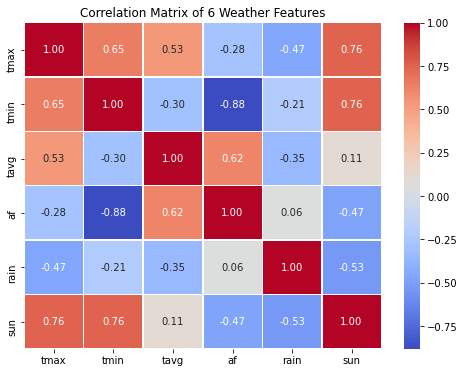

In [13]:
# Calculate the correlation matrix
correlation_matrix_6 = averages_by_station_6.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix_6)

# (Optional) Visualizing the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix_6, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of 6 Weather Features")
plt.show()

In [14]:
# Calculate the average for the specified columns excluding NaN values
columns_to_average = ['tavg', 'af', 'rain', 'sun']
# Group by 'station' and calculate the mean for each station while excluding NaN
averages_by_station = reformat_df.groupby('Station')[columns_to_average].mean()

# Display the averages by station
print(averages_by_station.head())

                  tavg        af        rain         sun
Station                                                 
aberporth     2.607464  1.492537   76.175000  128.641955
armagh        3.641601  3.275591   68.913213  104.269217
ballypatrick  2.916455  2.582712  110.185442  106.663636
bradford      3.295409  3.728850   72.988864  104.586547
braemar       3.896456  8.626289   75.877158   98.446739


Correlation Matrix:
          tavg        af      rain       sun
tavg  1.000000  0.623518 -0.346627  0.105873
af    0.623518  1.000000  0.055387 -0.470747
rain -0.346627  0.055387  1.000000 -0.534546
sun   0.105873 -0.470747 -0.534546  1.000000


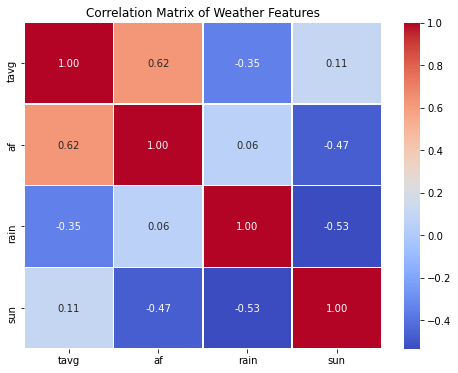

In [15]:
# Calculate the correlation matrix
correlation_matrix = averages_by_station.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# (Optional) Visualizing the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Weather Features")
plt.show()

In [16]:
# Reset index to include 'Station' as a column
averages_by_station = averages_by_station.reset_index()
# Save to CSV
averages_by_station.to_csv('averages_by_station.csv', index=False)
# Define the file path
file_path = r"C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part1_averages_by_station.csv"
# Save DataFrame to CSV
averages_by_station.to_csv(file_path, index=False)  # Set index=False to avoid saving the index column
print(f"DataFrame saved as '{file_path}'")

DataFrame saved as 'C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part1_averages_by_station.csv'


C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

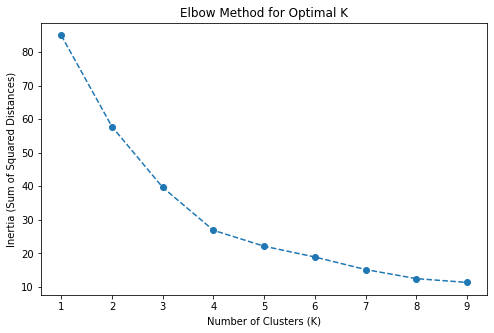

In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

# Selecting only numerical weather data for clustering
columns_to_cluster = ['tavg', 'af', 'rain','sun']
weather_data = averages_by_station[columns_to_cluster]

# Standardizing the data for better clustering performance
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(weather_data)

#Alternative: If data has many outliers, use RobustScaler instead.
scaler = RobustScaler()
scaled_data = scaler.fit_transform(weather_data)

# Finding the optimal number of clusters using the Elbow method
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method Graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal K')
plt.show()

C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

For K=2, Silhouette Score=0.291
For K=3, Silhouette Score=0.363
For K=4, Silhouette Score=0.389
For K=5, Silhouette Score=0.316
For K=6, Silhouette Score=0.289
For K=7, Silhouette Score=0.310
For K=8, Silhouette Score=0.305
For K=9, Silhouette Score=0.292


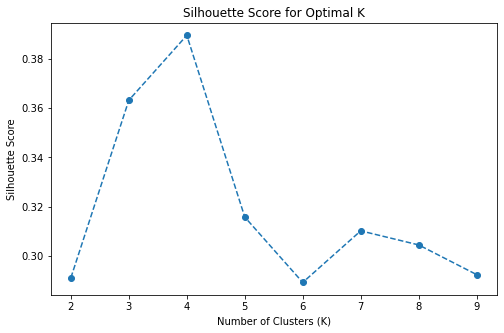

In [18]:
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the range of clusters
K_range = range(2, 10)  # Start from 2 since silhouette score is undefined for k=1

# Store silhouette scores
silhouette_scores = []

# Loop through different values of k
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_data)  # Get cluster labels
    
    score = silhouette_score(scaled_data, labels)  # Compute silhouette score
    silhouette_scores.append(score)
    print(f'For K={k}, Silhouette Score={score:.3f}')  # Print score for each k

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

In [19]:
# Choose an optimal number of clusters based on the elbow point (e.g., k=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
averages_by_station['cluster'] = kmeans.fit_predict(scaled_data)
averages_by_station

C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Station,tavg,af,rain,sun,cluster
0,aberporth,2.607464,1.492537,76.175000,128.641955,1
1,armagh,3.641601,3.275591,68.913213,104.269217,3
2,ballypatrick,2.916455,2.582712,110.185442,106.663636,2
3,bradford,3.295409,3.728850,72.988864,104.586547,3
4,braemar,3.896456,8.626289,75.877158,98.446739,0
5,camborne,2.534835,0.733456,90.062316,134.119367,1
6,cambridge,4.059487,3.557692,46.398413,125.000000,3
7,cardiff,3.816457,2.919065,98.087590,123.556054,3
8,chivenor,3.347207,1.703620,75.065769,138.594142,1
9,cwmystwyth,3.364792,5.113523,149.432712,97.186254,0


            Station  cluster
0         aberporth        1
1            armagh        3
2      ballypatrick        2
3          bradford        3
4           braemar        0
5          camborne        1
6         cambridge        3
7           cardiff        3
8          chivenor        1
9        cwmystwyth        0
10     dunstaffnage        2
11           durham        3
12       eastbourne        1
13      eskdalemuir        0
14         heathrow        3
15             hurn        3
16          lerwick        2
17         leuchars        3
18        lowestoft        1
19          manston        1
20            nairn        3
21       newtonrigg        3
22           oxford        3
23          paisley        2
24          ringway        3
25        rossonwye        3
26         shawbury        3
27        sheffield        3
28      southampton        3
29        stornoway        2
30  suttonbonington        3
31            tiree        2
32           valley        1
33       waddi

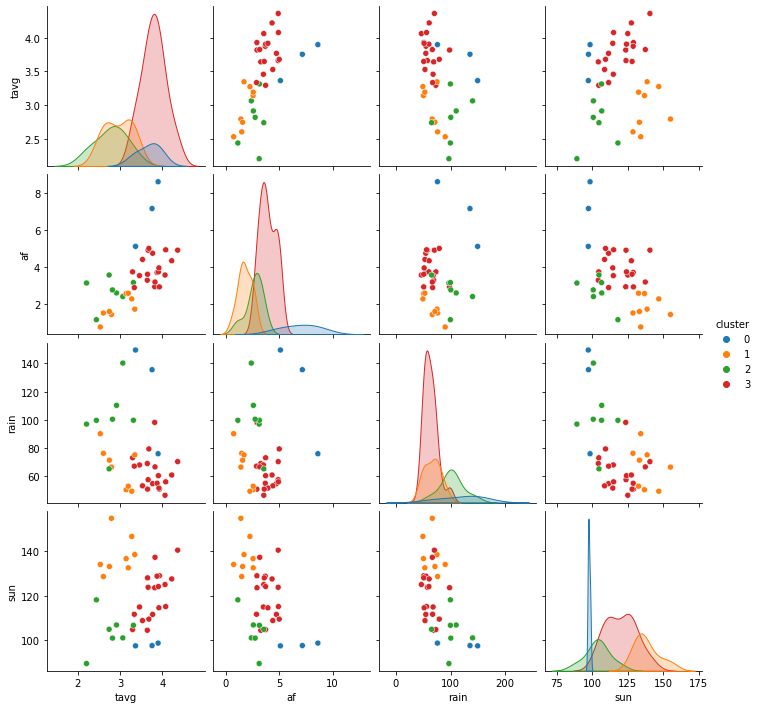

In [81]:
averages_by_station = averages_by_station.reset_index()
# Display the clustered stations
print(averages_by_station[['Station', 'cluster']])
# Visualize the clusters using a pairplot (2D representation)
sns.pairplot(averages_by_station, hue='cluster', vars=columns_to_cluster, palette='tab10')
plt.show()

In [20]:
# Count number of weather stations in each cluster
cluster_counts = averages_by_station['cluster'].value_counts().sort_index()

# Display the result
print("Number of weather stations in each cluster:")
print(cluster_counts)

Number of weather stations in each cluster:
0     3
1     8
2     7
3    19
Name: cluster, dtype: int64


In [21]:
# Define columns to compute averages
columns_to_average = ['tavg', 'af', 'rain', 'sun']
# Group by 'cluster' and calculate mean for each attribute
cluster_averages = averages_by_station.groupby('cluster')[columns_to_average].mean()
# Display the result
print(cluster_averages)

             tavg        af        rain         sun
cluster                                            
0        3.671717  6.970016  120.255379   97.651495
1        2.956112  1.786765   66.422069  138.216395
2        2.787819  2.668018  101.698362  103.802537
3        3.788536  3.903141   62.496522  120.093257


### Part 2: Can you predict if weather stations fall in the Northern Third of the UK, Central Third of the UK or Southern Third of the UK by using only the weather data?

In [87]:
df_part2 = averages_by_station
# Assuming df is your DataFrame
df_part2 = df_part2.drop(columns=['index','cluster'])

# Display the updated DataFrame
print(df_part2.head())  # Show the first few rows

        Station      tavg        af        rain         sun
0     aberporth  2.607464  1.492537   76.175000  128.641955
1        armagh  3.641601  3.275591   68.913213  104.269217
2  ballypatrick  2.916455  2.582712  110.185442  106.663636
3      bradford  3.295409  3.728850   72.988864  104.586547
4       braemar  3.896456  8.626289   75.877158   98.446739


In [88]:
# 1. Merge the two datasets on the 'Station' column to append the Latitude data
averages_by_station_part2 = pd.merge(df_part2, df_cleaned[['Station', 'Latitude']], on='Station', how='inner')

# 2. Remove duplicate rows (if any)
averages_by_station_part2 = averages_by_station_part2.drop_duplicates()

df_part2 = averages_by_station_part2
# 3. Check the resulting dataframe to ensure the Latitude column is added
print(df_part2.head())

           Station      tavg        af        rain         sun  Latitude
0        aberporth  2.607464  1.492537   76.175000  128.641955    52.139
996         armagh  3.641601  3.275591   68.913213  104.269217    54.352
3048  ballypatrick  2.916455  2.582712  110.185442  106.663636    55.181
3797      bradford  3.295409  3.728850   72.988864  104.586547    53.813
5189       braemar  3.896456  8.626289   75.877158   98.446739    57.006


In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Exclude the last 5 stations alphabetically
averages_by_station_part2 = averages_by_station_part2.sort_values('Station', ascending=True)
train_data = averages_by_station_part2.iloc[:-5]  # Exclude the last 5 stations
test_data = averages_by_station_part2.iloc[-5:]   # Last 5 stations as test set

# 2. Create a new column 'region' based on latitude
def assign_region(latitude):
    if latitude >= 57.233:  # Northern Third of the UK (>= 57.233)
        return 'Northern'
    elif latitude >= 53.567:  # Central Third of the UK (>= 53.567)
        return 'Central'
    else:  # Southern Third of the UK (< 53.567)
        return 'Southern'

# Apply the function to assign regions based on latitude
train_data['region'] = train_data['Latitude'].apply(assign_region)
test_data['region'] = test_data['Latitude'].apply(assign_region)

# 3. Define features and target
# features = ['tmax', 'tmin', 'tavg', 'af', 'rain', 'sun']
features = ['tavg', 'af', 'rain', 'sun']
X_train = train_data[features]
y_train = train_data['region']
X_test = test_data[features]
y_test = test_data['region']

# 4. Train a classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate the model
y_pred = model.predict(X_test)

# Display the classification report
print(classification_report(y_test, y_pred))

# You can also check accuracy directly
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

     Central       0.00      0.00      0.00         1
    Northern       0.00      0.00      0.00         1
    Southern       0.75      1.00      0.86         3

    accuracy                           0.60         5
   macro avg       0.25      0.33      0.29         5
weighted avg       0.45      0.60      0.51         5

Accuracy: 0.60


<ipython-input-89-950accf6fa99>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['region'] = train_data['Latitude'].apply(assign_region)
<ipython-input-89-950accf6fa99>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['region'] = test_data['Latitude'].apply(assign_region)
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

In [93]:
train_data.head()

,Station,tavg,af,rain,sun,Latitude,region
0,aberporth,2.607464,1.492537,76.175000,128.641955,52.139,Southern
996,armagh,3.641601,3.275591,68.913213,104.269217,54.352,Central
3048,ballypatrick,2.916455,2.582712,110.185442,106.663636,55.181,Central
3797,bradford,3.295409,3.728850,72.988864,104.586547,53.813,Central
5189,braemar,3.896456,8.626289,75.877158,98.446739,57.006,Central


In [91]:
test_data

,Station,tavg,af,rain,sun,Latitude,region
34368,valley,2.749329,1.573859,71.296237,133.177330,53.252,Southern
35485,waddington,3.647781,3.600000,50.762554,128.026082,53.175,Southern
36409,whitby,3.193683,2.568905,52.826549,132.586268,54.481,Central
36978,wickairport,2.742824,3.557848,65.130833,104.699142,58.454,Northern
38298,yeovilton,4.216854,4.332865,60.768680,127.539709,51.006,Southern


In [94]:
print(y_pred)

['Southern' 'Southern' 'Southern' 'Central' 'Southern']


### Part 3: Does the weather affect how happy we are?

In [95]:
import pandas as pd
# Load the spreadsheet
file_path = "C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Wellbeing data 2014_15.xlsx"
xls = pd.ExcelFile(file_path)

# Display sheet names to identify the relevant one
xls.sheet_names

# Load the "Happiness" sheet
df_happiness = pd.read_excel(xls, sheet_name="Happiness")

# Display the first few rows to understand its structure
df_happiness.head(10)

,"Happiness1 by UK, country, region, UA/ County in England, LADs in England, UAs in Wales, LAs in Scotland, LGDs in Northern Ireland, April 2014 to March 20152,4",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Per cent in each category on 11 point scale3:,NaN,NaN,NaN,Average (mean) rating,Confidence limits (95%),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sample size
2,NaN,NaN,NaN,NaN,Low,Medium,High,Very High,NaN,Low,...,High,NaN,NaN,Very High,NaN,NaN,Average (mean) rating,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0-4,5-6,7-8,9-10,NaN,0-4,...,7-8,NaN,NaN,9-10,NaN,NaN,NaN,NaN,NaN,NaN
4,Area Codes,Area names,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CV,...,CV,Lower limit,Upper limit,CV,Lower limit,Upper limit,CV,Lower limit,Upper limit,NaN
5,K02000001,UNITED KINGDOM,NaN,NaN,8.93,16.68,40.28,34.11,7.46,1.07,...,0.41,39.95,40.61,0.48,33.78,34.43,0.1,7.45,7.47,165160
6,E92000001,ENGLAND,NaN,NaN,8.95,16.73,40.47,33.85,7.45,1.2,...,0.46,40.1,40.84,0.55,33.49,34.22,0.11,7.44,7.47,120320
7,E12000001,NORTH EAST,NaN,NaN,10.77,17.05,39.06,33.13,7.34,3.44,...,1.56,37.86,40.25,1.79,31.96,34.29,0.37,7.29,7.4,11310
8,E06000047,NaN,County Durham UA,NaN,10.84,17.04,37.76,34.36,7.37,10.36,...,4.78,34.21,41.3,5.08,30.93,37.8,1.11,7.21,7.53,890
9,E06000005,NaN,Darlington UA,NaN,9.76,15.43,38.68,36.13,7.46,10.71,...,4.65,35.14,42.22,4.94,32.62,39.64,1.08,7.3,7.62,1000


In [96]:
import pandas as pd
from io import StringIO

# Define file path
file_path = r"C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Wellbeing data 2014_15.xlsx"

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Define relevant sheets and their corresponding column names
sheets = {
    "Happiness": "Happiness Score"
    #,"Life Satisfaction": "Life Satisfaction Score",
    #"Worthwhile": "Worthwhile Score",
    #"Anxiety": "Anxiety Score"
}

# Initialize an empty DataFrame for merging
df_final = None

# Process each sheet and merge the data
for sheet, score_col in sheets.items():
    df = pd.read_excel(xls, sheet_name=sheet, skiprows=5)  # Skip metadata rows
    df = df.rename(columns={
        df.columns[0]: "Area Code",
        df.columns[1]: "Area Name",
        df.columns[8]: score_col  # Assuming column 8 holds the score
    })
    df = df[["Area Code", "Area Name", score_col]].dropna(subset=["Area Name", score_col])
    
    if df_final is None:
        df_final = df  # First dataset
    else:
        df_final = df_final.merge(df, on=["Area Code", "Area Name"], how="inner")

# Load the region data
region_data = """Area Code,Region,Latitude,Longitude
E12000001,NORTH EAST,55.0,-1.9
E12000002,NORTH WEST,54.0,-2.6
E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2
E12000004,EAST MIDLANDS,53.0,-0.8
E12000005,WEST MIDLANDS,52.5,-2.3
E12000006,EAST,52.2,0.4
E12000007,LONDON,51.5,-0.1
E12000008,SOUTH EAST,51.3,-0.5
E12000009,SOUTH WEST,51.0,-3.2
W92000004,WALES,51.5,-3.2
S92000003,SCOTLAND,56.0,-3.2
N92000002,NORTHERN IRELAND,54.6,-5.9"""

df_region = pd.read_csv(StringIO(region_data))

# Merge with region data
df_final = df_final.merge(df_region, on="Area Code", how="inner").drop(columns=["Region"])

# Define the output file path
output_file_path = r"C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part3_format_Happiness_data_2014_15.csv"

# Save to CSV
df_final.to_csv(output_file_path, index=False)

print(f"DataFrame saved as '{output_file_path}'")

DataFrame saved as 'C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part3_format_Happiness_data_2014_15.csv'


In [97]:
df_final

,Area Code,Area Name,Happiness Score,Latitude,Longitude
0,E12000001,NORTH EAST,7.34,55.0,-1.9
1,E12000002,NORTH WEST,7.39,54.0,-2.6
2,E12000003,YORKSHIRE AND THE HUMBER,7.41,53.6,-1.2
3,E12000004,EAST MIDLANDS,7.51,53.0,-0.8
4,E12000005,WEST MIDLANDS,7.43,52.5,-2.3
5,E12000006,EAST,7.51,52.2,0.4
6,E12000007,LONDON,7.38,51.5,-0.1
7,E12000008,SOUTH EAST,7.54,51.3,-0.5
8,E12000009,SOUTH WEST,7.5,51.0,-3.2
9,W92000004,WALES,7.44,51.5,-3.2


In [98]:
# 1. Merge the two datasets on the 'Station' column to append the Latitude data
averages_by_station_part3 = pd.merge(averages_by_station_part2, df_cleaned[['Station', 'Longitude']], on='Station', how='inner')

# 2. Remove duplicate rows (if any)
averages_by_station_part3 = averages_by_station_part3.drop_duplicates()

averages_by_station_part3

# Define the output file path
output_file_path = r"C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part3_averages_by_station.csv"

# Save to CSV
averages_by_station_part3.to_csv(output_file_path, index=False)

print(f"DataFrame saved as '{output_file_path}'")

DataFrame saved as 'C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part3_averages_by_station.csv'


In [99]:
averages_by_station_part3.head()

,Station,tavg,af,rain,sun,Latitude,Longitude
0,aberporth,2.607464,1.492537,76.175000,128.641955,52.139,-4.570
996,armagh,3.641601,3.275591,68.913213,104.269217,54.352,-6.649
3048,ballypatrick,2.916455,2.582712,110.185442,106.663636,55.181,-6.153
3797,bradford,3.295409,3.728850,72.988864,104.586547,53.813,-1.772
5189,braemar,3.896456,8.626289,75.877158,98.446739,57.006,-3.396


In [101]:
# Merge the Region text data with weather data
from scipy.spatial import cKDTree

# Load the weather station data
weather_data_path = r"C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part3_averages_by_station.csv"
weather_df = pd.read_csv(weather_data_path)

# Ensure weather data has necessary columns
if "Latitude" not in weather_df.columns or "Longitude" not in weather_df.columns:
    raise ValueError("Weather data must contain 'Latitude' and 'Longitude' columns.")

# Convert latitude and longitude to NumPy arrays for efficient lookup
region_coords = df_final[["Latitude", "Longitude"]].to_numpy()
weather_coords = weather_df[["Latitude", "Longitude"]].to_numpy()

# Build KDTree for nearest neighbor search
tree = cKDTree(weather_coords)

# Find nearest weather station for each region
_, indices = tree.query(region_coords)

df_final["Nearest Station"] = weather_df.iloc[indices].reset_index(drop=True)["Station"]
df_final["tavg"] = weather_df.iloc[indices].reset_index(drop=True)["tavg"]
df_final["af"] = weather_df.iloc[indices].reset_index(drop=True)["af"]
df_final["rain"] = weather_df.iloc[indices].reset_index(drop=True)["rain"]
df_final["sun"] = weather_df.iloc[indices].reset_index(drop=True)["sun"]

# Define the output file path
output_file_path = r"C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part3_joined_dataset.csv"

# Save to CSV
df_final.to_csv(output_file_path, index=False)

print(f"DataFrame saved as '{output_file_path}'")

DataFrame saved as 'C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part3_joined_dataset.csv'


In [102]:
# Load the joined dataset we just saved
file_path = r"C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part3_joined_dataset.csv"
df_joined = pd.read_csv(file_path)

# Display basic information and the first few rows
df_joined.head()

,Area Code,Area Name,Happiness Score,Latitude,Longitude,Nearest Station,tavg,af,rain,sun
0,E12000001,NORTH EAST,7.34,55.0,-1.9,durham,3.767632,4.740591,54.619097,111.454594
1,E12000002,NORTH WEST,7.39,54.0,-2.6,newtonrigg,3.679231,5.003846,79.275794,109.330292
2,E12000003,YORKSHIRE AND THE HUMBER,7.41,53.6,-1.2,sheffield,3.335582,2.874700,67.059456,111.526163
3,E12000004,EAST MIDLANDS,7.51,53.0,-0.8,waddington,3.647781,3.600000,50.762554,128.026082
4,E12000005,WEST MIDLANDS,7.43,52.5,-2.3,shawbury,4.075124,4.927861,55.928205,115.005027


In [103]:
import scipy
import statsmodels
import statsmodels.api as sm
# Define independent variables (weather-related features)
X = df_joined[['tavg', 'af', 'rain', 'sun']]

# Define dependent variable (happiness score)
y = df_joined['Happiness Score']

# Add a constant to the model (for intercept)
X = sm.add_constant(X)

# Perform Ordinary Least Squares (OLS) regression
model = sm.OLS(y, X).fit()

# Display regression results
model.summary()

C:\Users\renny\Anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Happiness Score   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     1.555
Date:                Fri, 04 Apr 2025   Prob (F-statistic):              0.286
Time:                        21:41:49   Log-Likelihood:                 14.161
No. Observations:                  12   AIC:                            -18.32
Df Residuals:                       7   BIC:                            -15.90
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7115      0.722     10.678      0.000       6.004       9.419
tavg          -0.1840      0.144     -1.274      0.243      -0.525       0.157
af            -0.0197      0.044     -0.444      0.671      -0.125       0.085
rain           0.0010      0.002      0.545      0.603      -0.003       0.005
sun            0.0038      0.006      0.629      0.550      -0.010       0.018
==============================================================================
Omnibus:                        1.699   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.428   Jarque-Bera (JB):                0.863
Skew:                           0.181   Prob(JB):                        0.649
Kurtosis:                       1.736   Cond. No.                     3.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

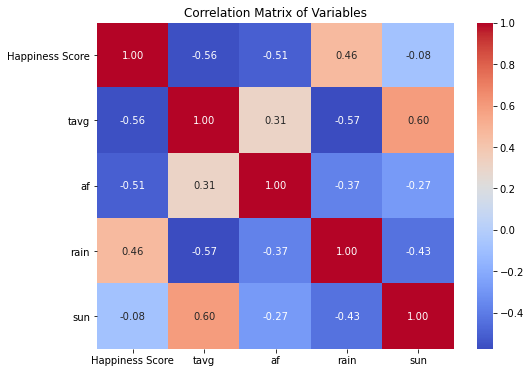

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Step 1: Check correlation between variables
correlation_matrix = df_joined[['Happiness Score', 'tavg', 'af', 'rain', 'sun']].corr()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Variables")
plt.show()

### Part 4: Perform clustering on the well-being data.

In [23]:
import pandas as pd
from io import StringIO

# Define file path
file_path = r"C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Wellbeing data 2014_15.xlsx"

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Define relevant sheets and their corresponding column names
sheets = {
    "Happiness": "Happiness Score",
    "Life Satisfaction": "Life Satisfaction Score",
    "Worthwhile": "Worthwhile Score",
    "Anxiety": "Anxiety Score"
}

# Initialize an empty DataFrame for merging
df_final = None

# Process each sheet and merge the data
for sheet, score_col in sheets.items():
    df = pd.read_excel(xls, sheet_name=sheet, skiprows=5)  # Skip metadata rows
    df = df.rename(columns={
        df.columns[0]: "Area Code",
        df.columns[1]: "Area Name",
        df.columns[8]: score_col  # Assuming column 8 holds the score
    })
    df = df[["Area Code", "Area Name", score_col]].dropna(subset=["Area Name", score_col])
    
    if df_final is None:
        df_final = df  # First dataset
    else:
        df_final = df_final.merge(df, on=["Area Code", "Area Name"], how="inner")

# Load the region data
region_data = """Area Code,Region,Latitude,Longitude
E12000001,NORTH EAST,55.0,-1.9
E12000002,NORTH WEST,54.0,-2.6
E12000003,YORKSHIRE AND THE HUMBER,53.6,-1.2
E12000004,EAST MIDLANDS,53.0,-0.8
E12000005,WEST MIDLANDS,52.5,-2.3
E12000006,EAST,52.2,0.4
E12000007,LONDON,51.5,-0.1
E12000008,SOUTH EAST,51.3,-0.5
E12000009,SOUTH WEST,51.0,-3.2
W92000004,WALES,51.5,-3.2
S92000003,SCOTLAND,56.0,-3.2
N92000002,NORTHERN IRELAND,54.6,-5.9"""

df_region = pd.read_csv(StringIO(region_data))

# Merge with region data
df_final = df_final.merge(df_region, on="Area Code", how="inner").drop(columns=["Region"])

# Define the output file path
output_file_path = r"C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part4_reformat_wellbeing_data_2014_15.csv"

# Save to CSV
df_final.to_csv(output_file_path, index=False)

print(f"DataFrame saved as '{output_file_path}'")

DataFrame saved as 'C:\RWY\Edinburgh DSTI (24 - XX)\Practical Introduction to Data Science\Assessment\Assessment 3\Part4_reformat_wellbeing_data_2014_15.csv'


In [106]:
df_final

,Area Code,Area Name,Happiness Score,Life Satisfaction Score,Worthwhile Score,Anxiety Score,Latitude,Longitude
0,E12000001,NORTH EAST,7.34,7.55,7.73,3.01,55.0,-1.9
1,E12000002,NORTH WEST,7.39,7.56,7.81,2.91,54.0,-2.6
2,E12000003,YORKSHIRE AND THE HUMBER,7.41,7.54,7.82,2.96,53.6,-1.2
3,E12000004,EAST MIDLANDS,7.51,7.63,7.8,2.75,53.0,-0.8
4,E12000005,WEST MIDLANDS,7.43,7.56,7.75,2.63,52.5,-2.3
5,E12000006,EAST,7.51,7.65,7.85,2.83,52.2,0.4
6,E12000007,LONDON,7.38,7.5,7.73,3.01,51.5,-0.1
7,E12000008,SOUTH EAST,7.54,7.72,7.91,2.82,51.3,-0.5
8,E12000009,SOUTH WEST,7.5,7.67,7.86,2.84,51.0,-3.2
9,W92000004,WALES,7.44,7.55,7.77,2.93,51.5,-3.2


C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

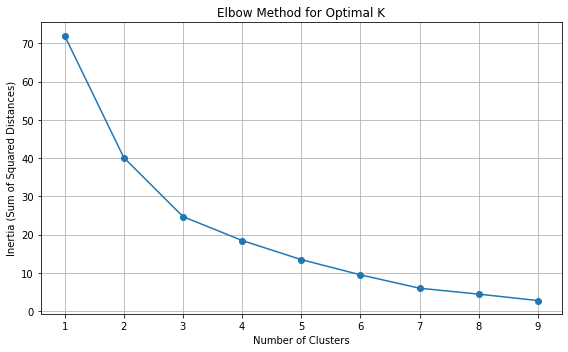

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select relevant numerical columns for clustering
features = ['Happiness Score', 'Life Satisfaction Score', 'Worthwhile Score', 'Anxiety Score', 'Latitude', 'Longitude']
X = df_final[features]

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

For K=2, Silhouette Score=0.502
For K=3, Silhouette Score=0.260
For K=4, Silhouette Score=0.188
For K=5, Silhouette Score=0.182
For K=6, Silhouette Score=0.180
For K=7, Silhouette Score=0.187
For K=8, Silhouette Score=0.135
For K=9, Silhouette Score=0.109


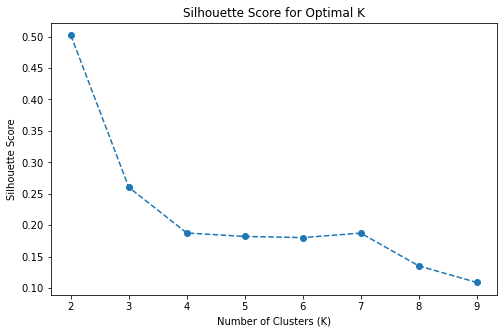

In [32]:
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the range of clusters
K_range = range(2, 10)  # Start from 2 since silhouette score is undefined for k=1

# Store silhouette scores
silhouette_scores = []

# Loop through different values of k
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)  # Get cluster labels
    
    score = silhouette_score(X_scaled, labels)  # Compute silhouette score
    silhouette_scores.append(score)
    print(f'For K={k}, Silhouette Score={score:.3f}')  # Print score for each k

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


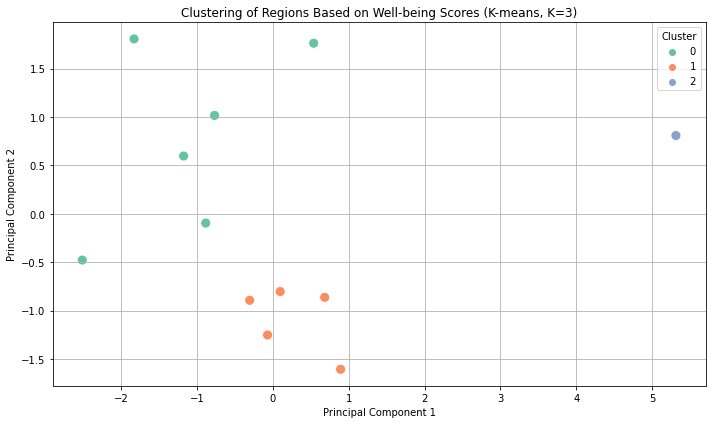

,Happiness Score,Life Satisfaction Score,Worthwhile Score,Anxiety Score,Latitude,Longitude
0,7.401667,7.558333,7.781667,2.943333,53.6,-2.033333
1,7.498000,7.646000,7.834000,2.774000,52.0,-1.280000
2,7.750000,7.900000,8.100000,2.780000,54.6,-5.900000


In [34]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Step 1: Select the relevant features for clustering
features_for_clustering = ['Happiness Score', 'Life Satisfaction Score', 'Worthwhile Score', 'Anxiety Score', "Latitude", "Longitude"]
X_cluster = df_final[features_for_clustering]

# Step 2: Standardize the features
X_scaled_cluster = scaler.fit_transform(X_cluster)

# Step 3: Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['Cluster'] = kmeans.fit_predict(X_scaled_cluster)

# Step 4: Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled_cluster)
df_final['PCA1'] = pca_components[:, 0]
df_final['PCA2'] = pca_components[:, 1]

# Step 5: Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
plt.title('Clustering of Regions Based on Well-being Scores (K-means, K=3)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display cluster centers in original feature space
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                               columns=features_for_clustering)
cluster_centers

C:\Users\renny\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


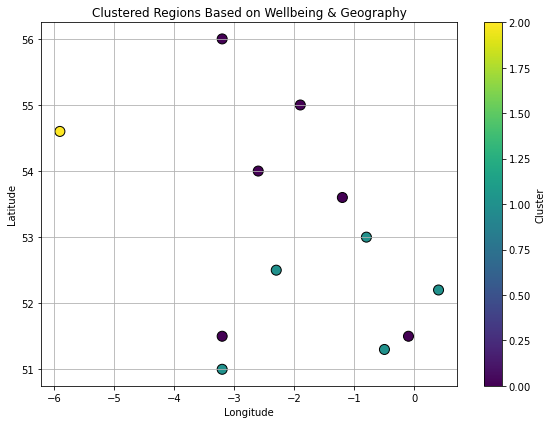

,Area Name,Cluster
0,NORTH EAST,0
1,NORTH WEST,0
2,YORKSHIRE AND THE HUMBER,0
3,EAST MIDLANDS,1
4,WEST MIDLANDS,1
5,EAST,1
6,LONDON,0
7,SOUTH EAST,1
8,SOUTH WEST,1
9,WALES,0


In [35]:
# Apply KMeans clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_final['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters using a scatter plot (Latitude vs. Longitude)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_final['Longitude'], df_final['Latitude'], c=df_final['Cluster'], cmap='viridis', s=100, edgecolor='k')
plt.title('Clustered Regions Based on Wellbeing & Geography')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

# Show cluster assignments with region names
df_final[['Area Name', 'Cluster']]